In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/omdena-time-series-analysis/data/Dhaka Tribune Complete Data.csv")

In [4]:
df.head()

,Unnamed: 0,Newspaper Name,Accident date,Header,News title,Deaths,Injured
0,0,Dhaka Tribune,Jun 26 2021,Two labourers killed in Dhaka road accident,2 killed in Dhaka road crash,2.0,2
1,1,Dhaka Tribune,Jun 23 2021,Three killed in Muktagacha road accident,Three killed in Muktagacha road...,3.0,0
2,2,Dhaka Tribune,Jun 19 2021,Truck-pickup van collision leaves 3 dead in Na...,Truck-pickup van collision leaves 3...,3.0,0
3,3,Dhaka Tribune,Jun 19 2021,"Couple, infant grandson killed in Bogra bus-au...",Bogra road crash kills 3,3.0,0
4,4,Dhaka Tribune,Jun 19 2021,Policeman killed in Dhaka road accident,Cop killed in Dhaka road crash,1.0,0


In [5]:
df.shape

(776, 7)

In [6]:
def convert_daily(df):
  start = datetime.datetime(2016,6,1)
  end = datetime.datetime(2021,6,1)
  index = pd.date_range(start, end).to_list()
  date = pd.DataFrame(index)
  date.columns = ['Date']
  df1 = df[['Accident date','Deaths']]
  result = pd.merge(date, df1, how="left",left_on='Date', right_on='Accident date')
  result.drop(columns='Accident date',inplace=True)
  result.fillna(0)
  return result

In [7]:
df.fillna(0,inplace=True)
df.isna().sum()

Unnamed: 0        0
Newspaper Name    0
Accident date     0
Header            0
News title        0
Deaths            0
Injured           0
dtype: int64

In [8]:
print(df.dtypes)

Unnamed: 0          int64
Newspaper Name     object
Accident date      object
Header             object
News title         object
Deaths            float64
Injured             int64
dtype: object


In [9]:
df['Accident date'] = pd.to_datetime(df['Accident date'])
df['month_year'] = pd.to_datetime(df['Accident date']).dt.to_period('M')    # monthly basic  (fatched month and year in a row from individual date row.) 
df['week_month_year'] = pd.to_datetime(df['Accident date']).dt.to_period('w')  # weekly basic (fatched first date of week and last date of week in a row from individual date row.)

In [10]:
df.head()

,Unnamed: 0,Newspaper Name,Accident date,Header,News title,Deaths,Injured,month_year,week_month_year
0,0,Dhaka Tribune,2021-06-26,Two labourers killed in Dhaka road accident,2 killed in Dhaka road crash,2.0,2,2021-06,2021-06-21/2021-06-27
1,1,Dhaka Tribune,2021-06-23,Three killed in Muktagacha road accident,Three killed in Muktagacha road...,3.0,0,2021-06,2021-06-21/2021-06-27
2,2,Dhaka Tribune,2021-06-19,Truck-pickup van collision leaves 3 dead in Na...,Truck-pickup van collision leaves 3...,3.0,0,2021-06,2021-06-14/2021-06-20
3,3,Dhaka Tribune,2021-06-19,"Couple, infant grandson killed in Bogra bus-au...",Bogra road crash kills 3,3.0,0,2021-06,2021-06-14/2021-06-20
4,4,Dhaka Tribune,2021-06-19,Policeman killed in Dhaka road accident,Cop killed in Dhaka road crash,1.0,0,2021-06,2021-06-14/2021-06-20


In [11]:
#temp =df.groupby(['month_year'],as_index = False)['Deaths'].sum() # monthly operation

temp =df.groupby(['week_month_year'],as_index = False)['Deaths'].sum() #weekly operation

In [12]:
temp.shape

(232, 2)

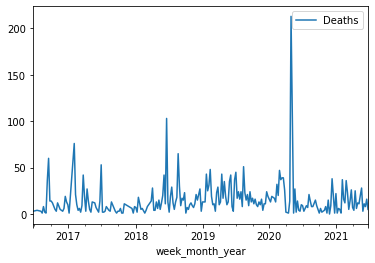

In [13]:
temp.plot(x='week_month_year')

In [14]:
print(temp.shape)


(232, 2)


# perform Data Pre-Processing on data and make  it ready time series model

In [15]:
temp.set_index('week_month_year', inplace=True)

In [16]:
temp.dtypes

Deaths    float64
dtype: object

In [17]:
data=temp.copy()

Check whether Data is stationery or not, if not make it stationery

In [18]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [19]:
adfuller(temp['Deaths'])

(-14.15693995906928,
 2.113561505295262e-26,
 0,
 231,
 {'1%': -3.4589796764641,
  '10%': -2.573482381701992,
  '5%': -2.8741347158661448},
 1897.2549426371677)

In [20]:
def adfuller_test(Temp):
  result = adfuller(Temp)
  labels = ['ADF Test stats' , 'p-value' , '#lags used', 'no of observations used']

  for value , label in zip(result , labels):
    print('{} : {}'.format(label , value))
  if result[1] <= 0.05:
    print("Strong evidence against the null hypo , henece we can reject the null hypo & data is stationary")
  else:
    print("weak evidence against the null hypo , henece we have failed to reject the null hypo & data is not stationary")

In [21]:
adfuller_test(temp['Deaths'])

ADF Test stats : -14.15693995906928
p-value : 2.113561505295262e-26
#lags used : 0
no of observations used : 231
Strong evidence against the null hypo , henece we can reject the null hypo & data is stationary


In [22]:
df = temp.copy()

In [23]:
#df['first_death_diff'] = df['Deaths']-df['Deaths'].shift(7)

 Examine if there is a seasonality in a data or not

In [24]:
temp['week'] = temp.index.week

In [25]:
temp['year'] = temp.index.year

In [26]:
temp.head()

,Deaths,week,year
week_month_year,,,
2016-06-20/2016-06-26,3.0,25,2016
2016-07-11/2016-07-17,4.0,28,2016
2016-08-01/2016-08-07,3.0,31,2016
2016-08-08/2016-08-14,1.0,32,2016
2016-08-15/2016-08-21,8.0,33,2016


In [27]:
pivot = temp.pivot_table(values='Deaths', index='week',columns='year')

In [28]:
pivot

year,2016,2017,2018,2019,2020,2021
week,,,,,,
1,NaN,1.0,7.0,13.0,16.0,1.0
2,NaN,NaN,2.0,13.0,13.0,6.0
3,NaN,NaN,18.0,13.0,19.0,5.0
4,NaN,NaN,NaN,43.0,18.0,1.0
5,NaN,76.0,5.0,25.0,17.0,37.0
6,NaN,21.0,6.0,31.0,13.0,16.0
7,NaN,10.0,NaN,48.0,32.0,12.0
8,NaN,4.0,1.0,19.0,20.0,36.0
9,NaN,6.0,4.0,10.0,47.0,23.0


Text(0, 0.5, 'Deaths')

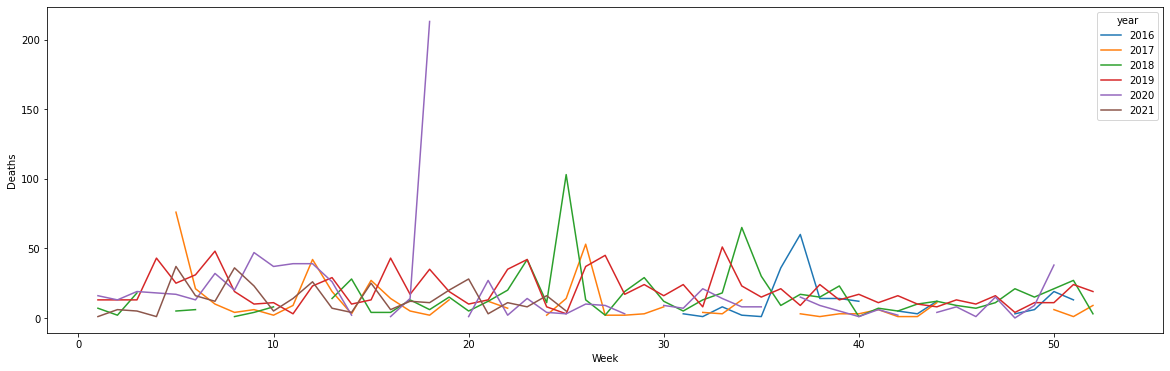

In [29]:
pivot.plot(figsize= (20,6))
plt.xlabel('Week')
plt.ylabel('Deaths')

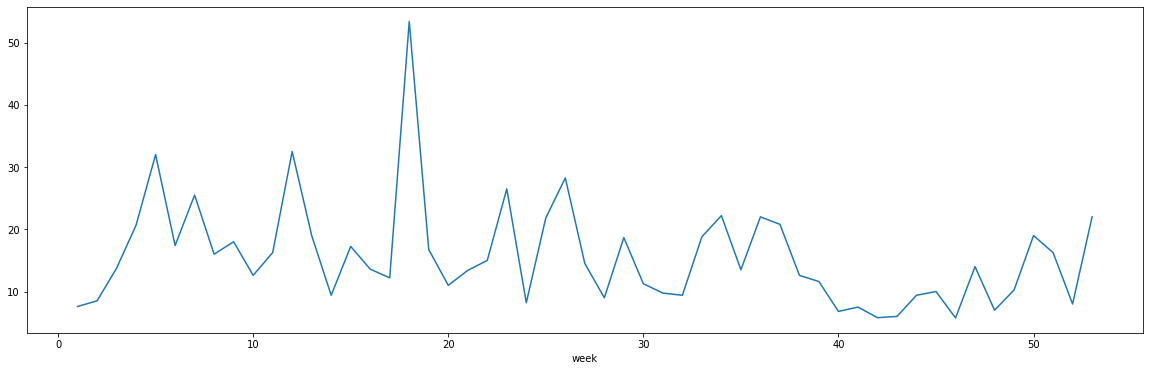

In [31]:
weekly_seasonality = pivot.mean(axis=1)
weekly_seasonality.plot(figsize =(20,6))

Build Time Series Model using Moving Average

In [32]:
temp.head()

,Deaths,week,year
week_month_year,,,
2016-06-20/2016-06-26,3.0,25,2016
2016-07-11/2016-07-17,4.0,28,2016
2016-08-01/2016-08-07,3.0,31,2016
2016-08-08/2016-08-14,1.0,32,2016
2016-08-15/2016-08-21,8.0,33,2016


In [33]:
#df =df.dropna()

In [34]:
#df.isna().sum()

In [35]:
value = pd.DataFrame(temp['Deaths'])
temp_df =pd.concat([value, temp['Deaths'].rolling(window = 7).mean()], axis=1)

In [36]:
temp_df.columns = ['actual' , 'forecast']

In [37]:
temp_df.head(20)

,actual,forecast
week_month_year,,
2016-06-20/2016-06-26,3.0,NaN
2016-07-11/2016-07-17,4.0,NaN
2016-08-01/2016-08-07,3.0,NaN
2016-08-08/2016-08-14,1.0,NaN
2016-08-15/2016-08-21,8.0,NaN
2016-08-22/2016-08-28,2.0,NaN
2016-08-29/2016-09-04,1.0,3.142857
2016-09-05/2016-09-11,36.0,7.857143
2016-09-12/2016-09-18,60.0,15.857143


Evaluate Moving Average model.

In [64]:
from sklearn.metrics import mean_squared_error

In [65]:
np.sqrt(mean_squared_error(temp_df['forecast'][6:], temp_df['actual'][6:]))

17.551289683390735

Apply ARIMA on data

In [66]:
scaled_data = data.copy()


In [67]:
#min-max normalization
def normalize(data,min, max):
  for i in range(len(data)):
    data.iloc[i] =((data.iloc[i] - min )/(( max - min )))
  return data


In [68]:
#MIN-MAX denormalization
def denormalize(data,min,max):
  for i in range(len(data)):
    data.iloc[i] = round(data.iloc[i]*(max - min) + min)
  return data 

In [69]:
#scaled_data['Deaths'] = scaler.fit_transform(data)
min = np.min(scaled_data['Deaths'])
max = np.max(scaled_data['Deaths'])
normalize(scaled_data ,min , max)


,Deaths
week_month_year,
2016-06-20/2016-06-26,0.014085
2016-07-11/2016-07-17,0.018779
2016-08-01/2016-08-07,0.014085
2016-08-08/2016-08-14,0.004695
2016-08-15/2016-08-21,0.037559
...,...
2021-05-24/2021-05-30,0.014085
2021-05-31/2021-06-06,0.051643
2021-06-07/2021-06-13,0.037559


In [70]:
#denormalize(scaled_data,min,max)


In [71]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

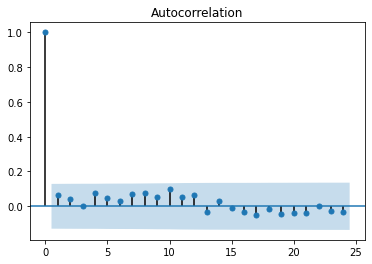

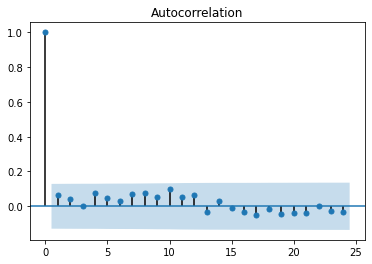

In [72]:
#plot_acf(data['Deaths'])
plot_acf(scaled_data)
#plot_acf(df['first_death_diff'])

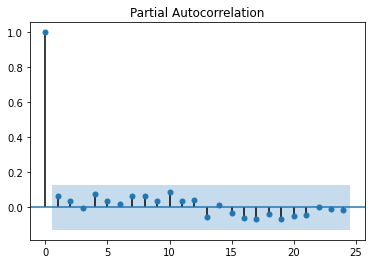

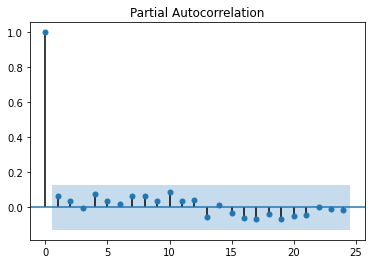

In [73]:
#plot_pacf(data['Deaths'])

plot_pacf(scaled_data)
#plot_pacf(df['first_death_diff'])

In [74]:
scaled_data.shape
#data.shape


(232, 1)

In [75]:
#training_data = data[:225]
#test_data = data[225:]

training_data = scaled_data[:225]
test_data = scaled_data[225:]
#training_data = df['first_death_diff'][:195]
#test_data = df['first_death_diff'][195:]

In [76]:
 from statsmodels.tsa.arima_model import ARIMA

In [77]:
arima = ARIMA(training_data,order=(4,1,4))

In [78]:
model = arima.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



Predict using ARIMA model

In [79]:
from sklearn import metrics

In [80]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [81]:
predictions = model.forecast(steps=len(test_data))[0]


In [82]:
print("RMSE")
print(np.sqrt(mean_squared_error(test_data, predictions)))
print("MSE")
print(metrics.mean_squared_error(test_data, predictions))
print("R2")
print(metrics.r2_score(test_data, predictions))
print("MAPE")
print(mape(test_data['Deaths'].to_list(), predictions))

RMSE
0.03493303661927191
MSE
0.0012203170474433926
R2
0.18581523344912843
MAPE
92.58733213311031


In [83]:
pred = pd.DataFrame(predictions)
print("Predicted value")
denormalize(pred,min,max)

Predicted value


,0
0,20.0
1,18.0
2,11.0
3,15.0
4,21.0
5,14.0
6,12.0


In [86]:
print("Actual value")
denormalize(test_data['Deaths'],min,max)

Actual value


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



week_month_year
2021-05-10/2021-05-16    20.0
2021-05-17/2021-05-23    28.0
2021-05-24/2021-05-30     3.0
2021-05-31/2021-06-06    11.0
2021-06-07/2021-06-13     8.0
2021-06-14/2021-06-20    16.0
2021-06-21/2021-06-27     5.0
Freq: W-SUN, Name: Deaths, dtype: float64

Actual value : [20.0, 28.0, 3.0, 11.0, 8.0, 16.0, 5.0]
predicted value: [20.0, 18.0, 11.0, 15.0, 21.0, 14.0, 12.0]


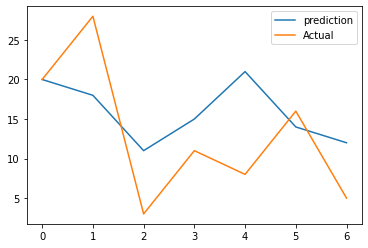

In [95]:
print("Actual value : {}".format(test_data['Deaths'].to_list()))
print("predicted value: {}".format(pred[0].to_list()))
import matplotlib.pyplot as plt
plt.plot(pred)
plt.plot(test_data['Deaths'].to_list())
plt.legend(['prediction', 'Actual'])

# Facebook prophet

In [96]:
scaled_data =data.copy()
normalize(scaled_data,min,max)
fb =scaled_data.reset_index()

In [97]:
fb['week_month_year'] = fb['week_month_year'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d %H:%M:%S').add('.000')

In [98]:
fb

,week_month_year,Deaths
0,2016-06-20 00:00:00.000,0.014085
1,2016-07-11 00:00:00.000,0.018779
2,2016-08-01 00:00:00.000,0.014085
3,2016-08-08 00:00:00.000,0.004695
4,2016-08-15 00:00:00.000,0.037559
...,...,...
227,2021-05-24 00:00:00.000,0.014085
228,2021-05-31 00:00:00.000,0.051643
229,2021-06-07 00:00:00.000,0.037559
230,2021-06-14 00:00:00.000,0.075117


In [99]:
import fbprophet
import pandas as pd
from fbprophet import Prophet

In [100]:
df_prophet =fb.rename(columns={'week_month_year' : 'ds', 'Deaths': 'y'})


In [101]:

df_prophet.head()

,ds,y
0,2016-06-20 00:00:00.000,0.014085
1,2016-07-11 00:00:00.000,0.018779
2,2016-08-01 00:00:00.000,0.014085
3,2016-08-08 00:00:00.000,0.004695
4,2016-08-15 00:00:00.000,0.037559


In [102]:
#initialize the model
m = Prophet()

In [103]:
model = m.fit(df_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Create Future data for your prediction purpose

In [104]:
model.seasonalities

OrderedDict([('yearly',
              {'condition_name': None,
               'fourier_order': 10,
               'mode': 'additive',
               'period': 365.25,
               'prior_scale': 10.0})])

In [105]:
future_global = model.make_future_dataframe(periods=7,freq='D')

In [106]:
future_global

,ds
0,2016-06-20
1,2016-07-11
2,2016-08-01
3,2016-08-08
4,2016-08-15
...,...
234,2021-06-24
235,2021-06-25
236,2021-06-26
237,2021-06-27


In [107]:
df_prophet.shape

(232, 2)

In [108]:
future_global.shape

(239, 1)

In [109]:
df_prophet['ds'].tail()

227    2021-05-24 00:00:00.000
228    2021-05-31 00:00:00.000
229    2021-06-07 00:00:00.000
230    2021-06-14 00:00:00.000
231    2021-06-21 00:00:00.000
Name: ds, dtype: object

Doing Predictions on your Future data

In [110]:
prediction =  model.predict(future_global)
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-20,0.050526,-0.039399,0.184808,0.050526,0.050526,0.019115,0.019115,0.019115,0.019115,0.019115,0.019115,0.0,0.0,0.0,0.069641
1,2016-07-11,0.051181,-0.065233,0.152134,0.051181,0.051181,-0.004243,-0.004243,-0.004243,-0.004243,-0.004243,-0.004243,0.0,0.0,0.0,0.046938
2,2016-08-01,0.051836,-0.068315,0.141605,0.051836,0.051836,-0.020513,-0.020513,-0.020513,-0.020513,-0.020513,-0.020513,0.0,0.0,0.0,0.031322
3,2016-08-08,0.052054,-0.054796,0.154426,0.052054,0.052054,-0.000967,-0.000967,-0.000967,-0.000967,-0.000967,-0.000967,0.0,0.0,0.0,0.051087
4,2016-08-15,0.052272,-0.043660,0.173728,0.052272,0.052272,0.014149,0.014149,0.014149,0.014149,0.014149,0.014149,0.0,0.0,0.0,0.066421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,2021-06-24,0.066084,-0.018708,0.194232,0.066084,0.066084,0.015989,0.015989,0.015989,0.015989,0.015989,0.015989,0.0,0.0,0.0,0.082074
235,2021-06-25,0.066053,-0.024183,0.188470,0.066053,0.066053,0.015240,0.015240,0.015240,0.015240,0.015240,0.015240,0.0,0.0,0.0,0.081293
236,2021-06-26,0.066022,-0.033497,0.187437,0.066022,0.066022,0.014524,0.014524,0.014524,0.014524,0.014524,0.014524,0.0,0.0,0.0,0.080546
237,2021-06-27,0.065991,-0.029021,0.184666,0.065991,0.065991,0.013830,0.013830,0.013830,0.013830,0.013830,0.013830,0.0,0.0,0.0,0.079821


In [111]:
prediction[['ds', 'yhat' , 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
234,2021-06-24,0.082074,-0.018708,0.194232
235,2021-06-25,0.081293,-0.024183,0.188470
236,2021-06-26,0.080546,-0.033497,0.187437
237,2021-06-27,0.079821,-0.029021,0.184666
238,2021-06-28,0.079104,-0.030659,0.184013


Visualise your predictions

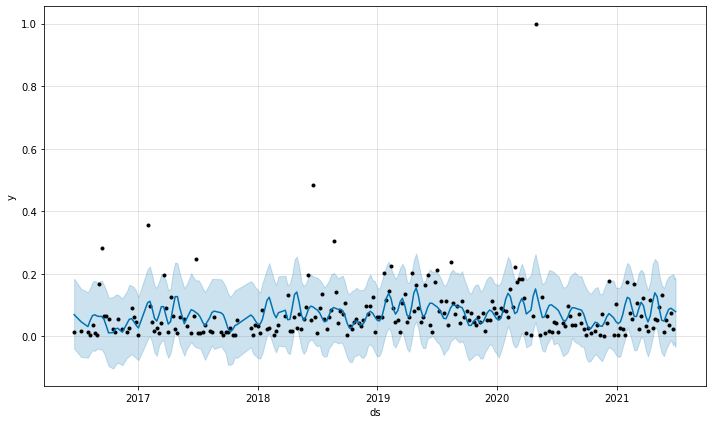

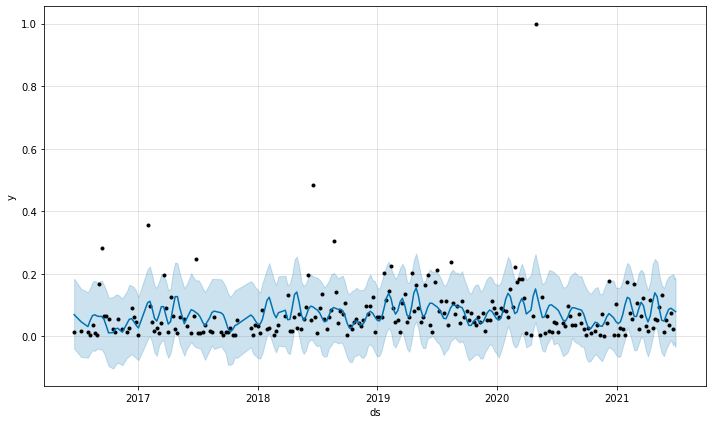

In [112]:
model.plot(prediction)

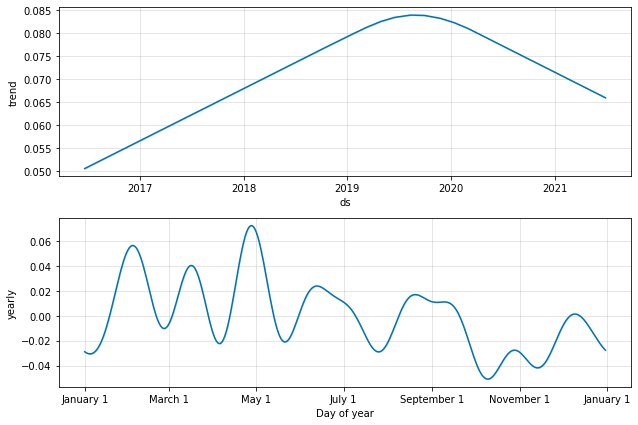

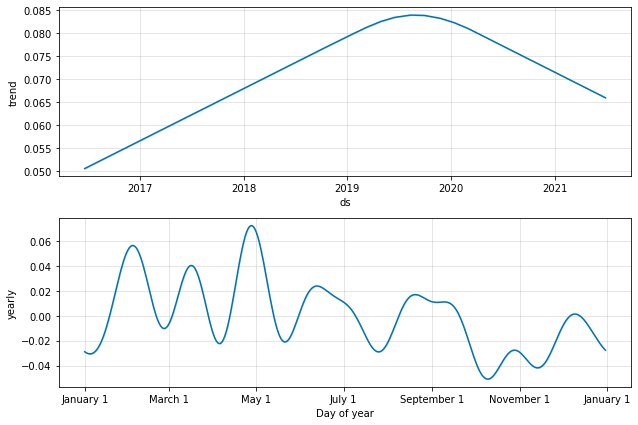

In [113]:
model.plot_components(prediction)

In [114]:
from fbprophet.plot import add_changepoints_to_plot

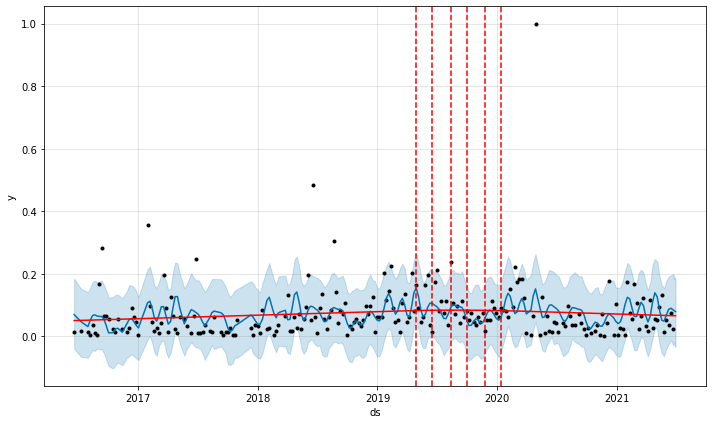

In [115]:
fig = model.plot(prediction)
a = add_changepoints_to_plot(fig.gca() , model, prediction)

Cross Validating your time series data

In [116]:
from fbprophet.diagnostics import cross_validation

In [126]:
df_cv = cross_validation(model , horizon='30 days', period='15 days',initial='366 days' )

INFO:fbprophet:Making 93 forecasts with cutoffs between 2017-07-02 00:00:00 and 2021-05-22 00:00:00


In [127]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-07-03,0.227343,0.177425,0.276273,0.009390,2017-07-02
1,2017-07-10,0.169198,0.113846,0.220907,0.009390,2017-07-02
2,2017-07-17,0.114298,0.062866,0.165949,0.014085,2017-07-02
3,2017-07-24,0.111465,0.062534,0.163044,0.037559,2017-07-02
4,2017-07-24,0.034563,-0.017602,0.091277,0.037559,2017-07-17


 Obtain Performance metrics for my data

In [128]:
from fbprophet.diagnostics import performance_metrics

In [129]:
df_performance = performance_metrics(df_cv)
df_performance.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,3 days,0.004373,0.066127,0.048289,0.612854,0.814969
1,4 days,0.003863,0.062150,0.047525,0.566825,0.810811
2,5 days,0.003859,0.062119,0.048926,0.471170,0.833680
3,6 days,0.004779,0.069128,0.050305,0.471170,0.851351
4,7 days,0.004350,0.065957,0.049323,0.667837,0.882883


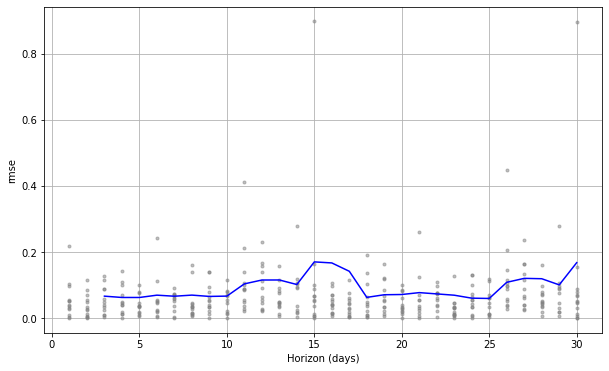

In [130]:
from fbprophet.plot import plot_cross_validation_metric
df_performance = plot_cross_validation_metric(df_cv,metric='rmse')

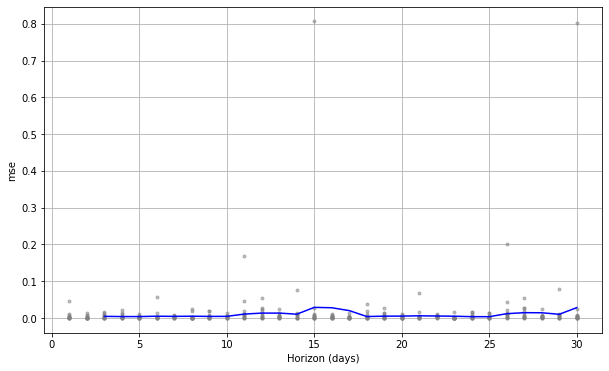

In [131]:
df_performance = plot_cross_validation_metric(df_cv,metric='mse')